In [1]:
import pandas as pd
import Bio
from Bio import SeqIO
from Bio.Alphabet import generic_dna
from Bio.Seq import Seq
import pickle
from collections import Counter
import timeit
import copy
###
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import igraph
import seaborn
###import packages
from scEasyMode import mousefilter
from scEasyMode import clusterplot
from scEasyMode import pymulti
from scEasyMode import sceasy


### purpose: 
#### match read1 and read2, then slice out the barcodes and assign barcodes, frequency to each cell barcode

### Ran cut_5prime_2.sh on fastqs beforehand.

### merged all r1 and r2 post trimming into one for processing here.

In [2]:
#####define files
#######note that R1 = R2 , vice versa. therefore the important 10x 3' read is in read1_list
samples = [105,106,107,108,109,110,111,112]
barcodes = ['097','098','099',100,101,102,103,104]
for sample,barcode in zip(samples,barcodes):
    ####get raw fastqs for gbcs
    read1_name = "gbcs/trimmed_L0"+str(sample)+"_R1.out.gz"
    read2_name = "gbcs/trimmed_L0"+str(sample)+"_R2.out.gz"
    ####define 10x barcodes whitelist    
    bc10xfile = "pymulti/L0"+str(barcode)+'.barcodes.tsv'
    bcs10x = pd.read_csv(bc10xfile,sep='\t',header=None)
    bcs10x['10x'] = bcs10x.apply(lambda row: row[0][:-2],axis=1)
    bcs10x = bcs10x['10x'].tolist()
    ####subset barcodes using GBC known barcodes
    bcsmulti = pd.read_csv('gbcs.cleanintx.csv',index_col=0)['0'].tolist()
    ####define parameters
    sampname = 'GBCs_'+str(barcode)
    ###split and call with pymulti
    pymulti.pymulti(R1=read1_name,R2=read2_name,bcsmulti=bcsmulti,bcs10x=bcs10x,len_10x=16,len_umi=12,len_multi=18,gbc_thresh=0.0,sampname=sampname,
            split=True,plots=False,hamming=False,thresh=False,pct_only=True,huge=True)


assuming huge fastqs.
file is huge. not saving.
Multiseq rate is:  97.68762044029395
10X Cell Barcode rate is:  88.92393705994088
Duplication rate is:  84.58102853031046
Number of GBCs:  555
saving file  GBCs_097
assuming huge fastqs.
file is huge. not saving.
Multiseq rate is:  97.69066011473426
10X Cell Barcode rate is:  88.43308582119427
Duplication rate is:  88.51883753108912
Number of GBCs:  555
saving file  GBCs_098
assuming huge fastqs.
file is huge. not saving.
Multiseq rate is:  97.67725038918172
10X Cell Barcode rate is:  89.49501741689437
Duplication rate is:  88.82468998692791
Number of GBCs:  553
saving file  GBCs_099
assuming huge fastqs.
file is huge. not saving.
Multiseq rate is:  97.82564170180616
10X Cell Barcode rate is:  87.55717065047256
Duplication rate is:  88.85260014062088
Number of GBCs:  551
saving file  GBCs_100
assuming huge fastqs.
file is huge. not saving.
Multiseq rate is:  97.62845550672414
10X Cell Barcode rate is:  88.79979743045632
Duplication rate i

# Sanity check

In [3]:
###define
samples = ['097']
bcfile1 = 'pymulti/bcsmulti1.csv'
bcfile2 = 'pymulti/bcsmulti2.csv'
###readin
matrices = []
gbcs = []
for sample in samples:
    sampname = 'pymulti/L0'+sample+'.matrix.h5'
    matrices.append(sc.read_10x_h5(sampname))
    sampname = 'pymulti/GBCs_'+sample+'_calls_short.tsv'
    gbcs.append(pd.read_csv(sampname,sep=' ',index_col=0))
###
metas = [] 
i = 0
for matrix in matrices:
    if i <= 3:
        metas.append(sceasy.overlay_meta(matrix,bcfile1,sampname='L0'+samples[i]))
        print(bcfile1,i)
    else:
        metas.append(sceasy.overlay_meta(matrix,bcfile2,sampname='L0'+samples[i]))
        print(bcfile2,i)
    i+=1
####
i=0
for meta,gbc in zip(metas,gbcs):
    metas[i] = sceasy.overlay_gbcs(meta,gbc)
    i+=1

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


pymulti/bcsmulti1.csv 0


Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Total number of cells: 20802
Number of cells after min count filter: 20802
Number of cells after max count filter: 20802
Number of cells after MT filter: 20802


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 20802
Total number of genes: 33538
Number of genes after cell filter: 16008
Total number of genes: 33538
Number of genes after cell filter: 16008

 Number of highly variable genes: 3000


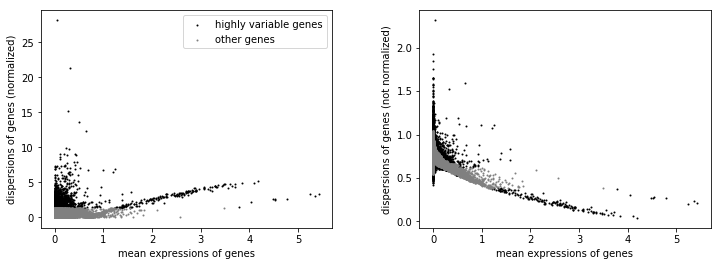


 Number of highly variable genes: 3000


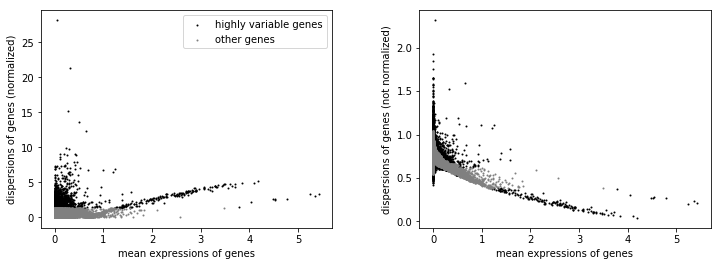

(20802, 16008)
(20802, 16008)


In [4]:
###qc
qcs = []
for matrix in metas:
    qcs.append(sceasy.qc_all(matrix,suppress_plots=True))
###normalize
mt_thresh = 1.0
min_cells = 20
sig_pct = 0.0
min_counts = 0
min_genes = 0
max_counts = 1000000
##filter
filters = []
for qc in qcs:
    filters.append(sceasy.filters(qc,mt_thresh=mt_thresh,min_cells=min_cells,sig_pct=sig_pct,min_counts=min_counts,min_genes=min_genes,max_counts=max_counts)[0])


/home/johnny/.local/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../home/johnny/.local/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/johnny/.local/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../home/johnny/.local/lib/python3.6/site-packag

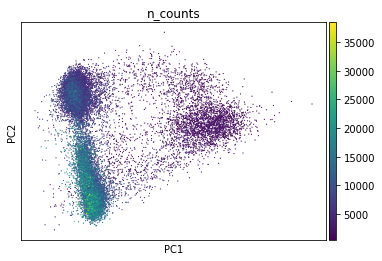

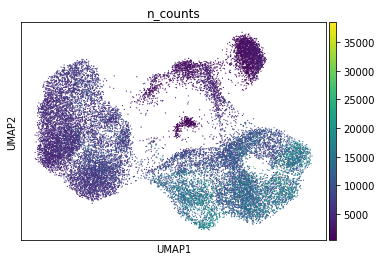

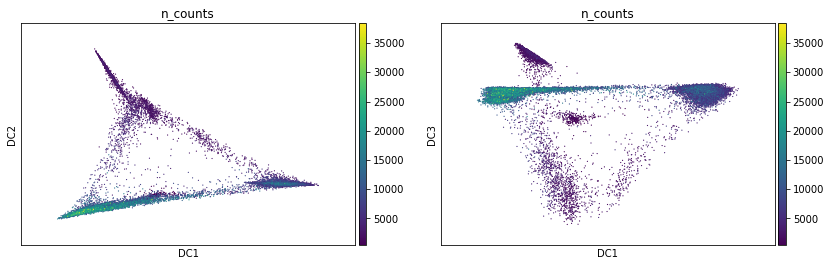

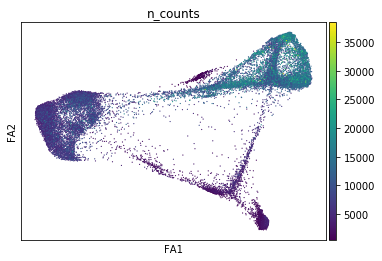

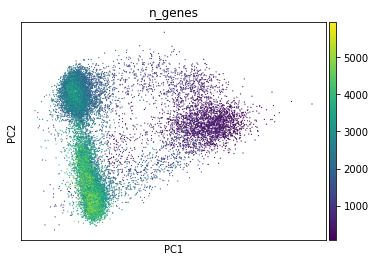

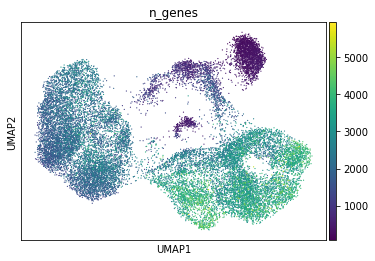

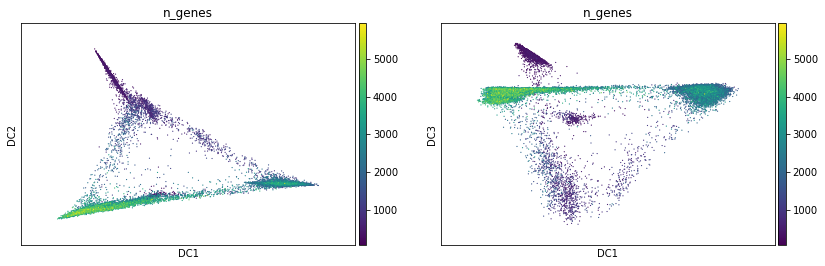

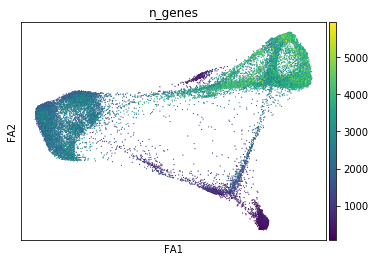

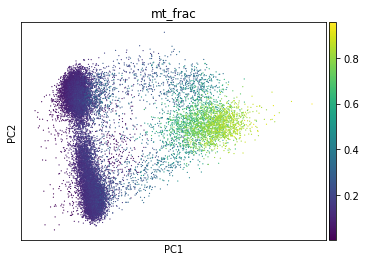

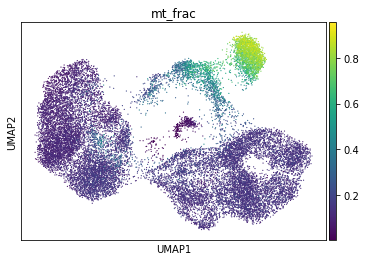

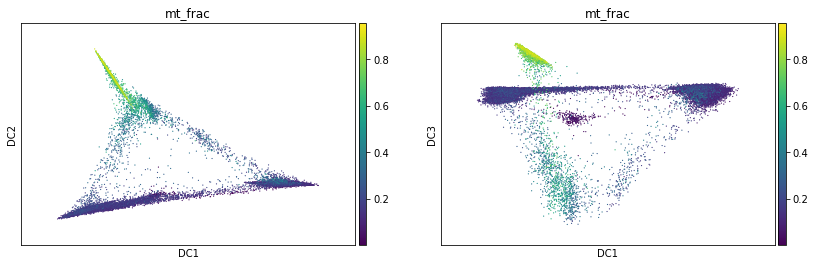

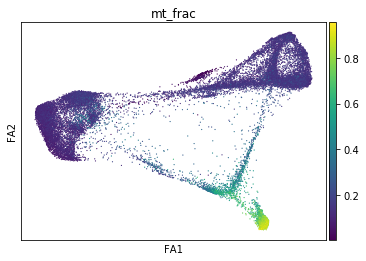

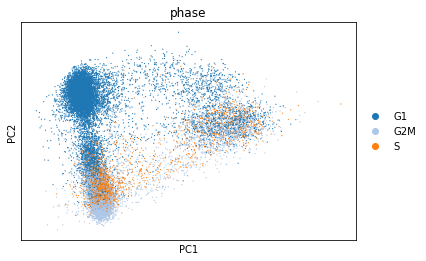

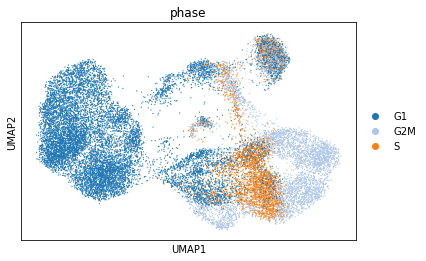

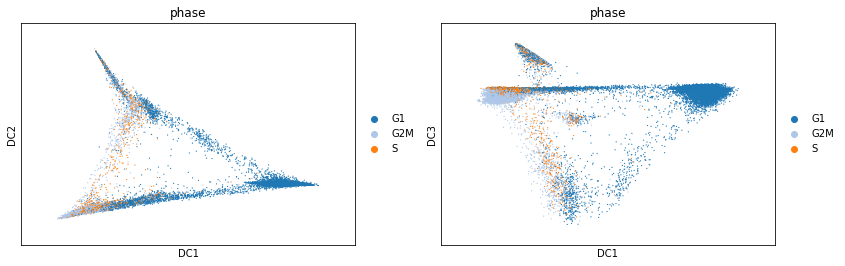

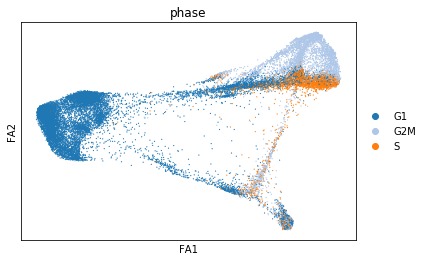

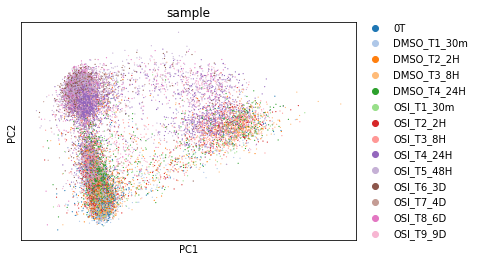

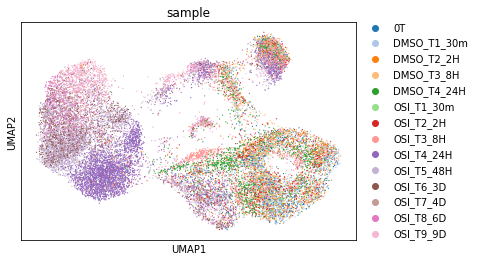

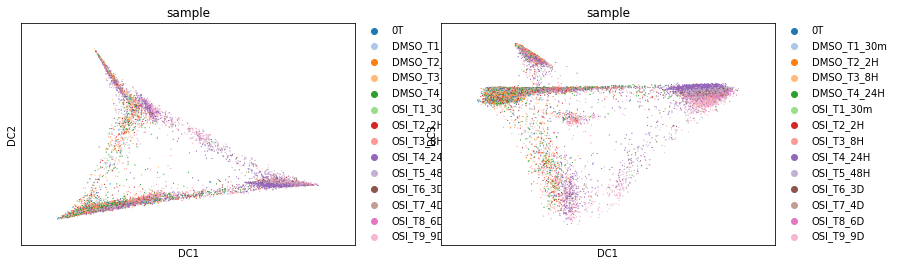

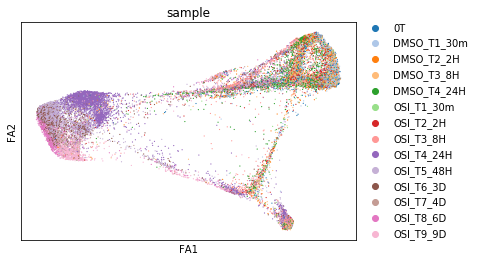

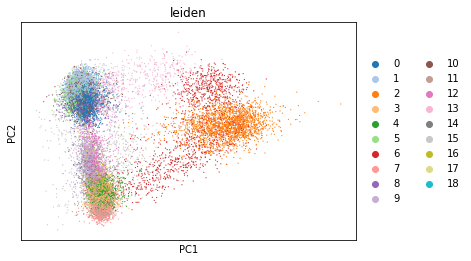

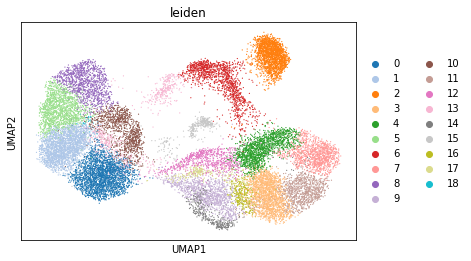

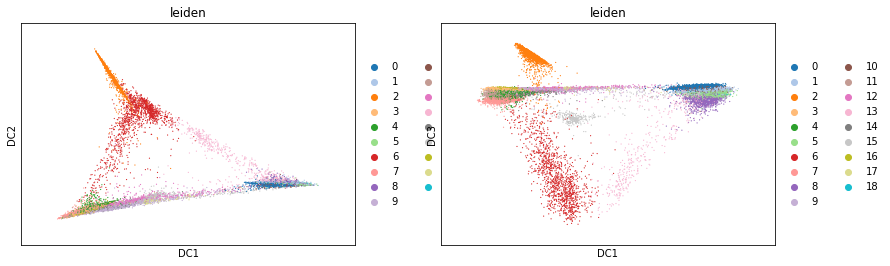

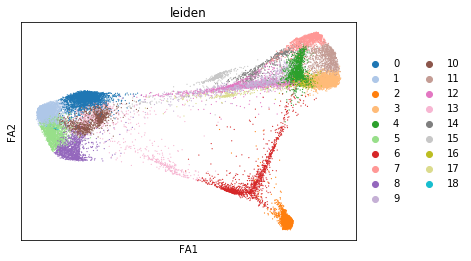

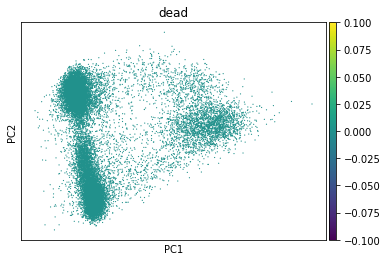

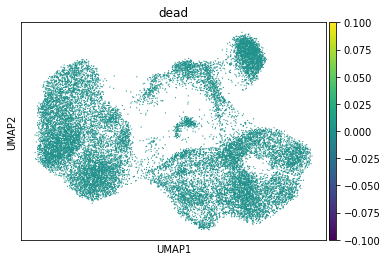

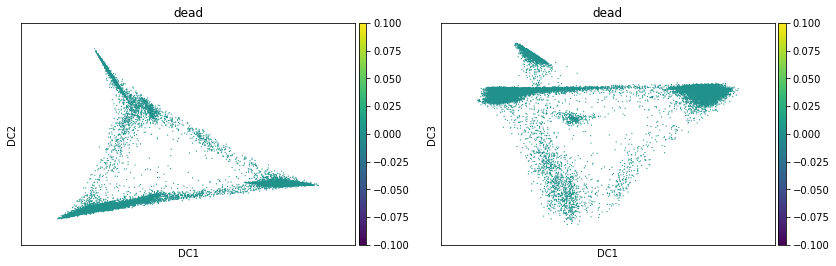

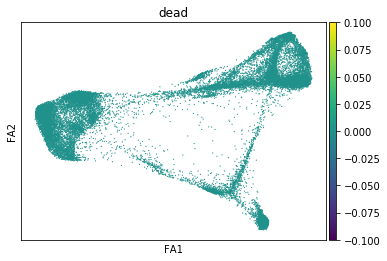

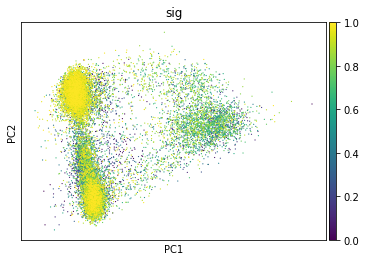

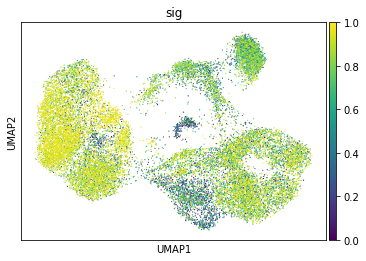

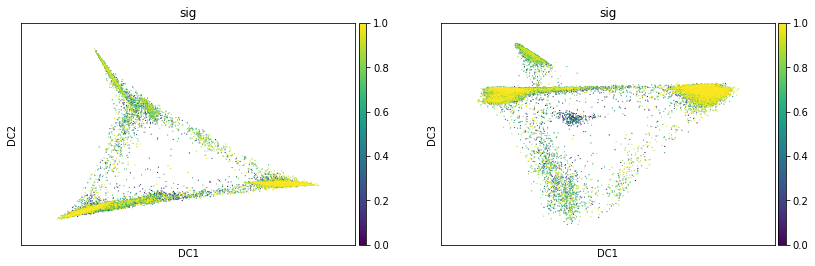

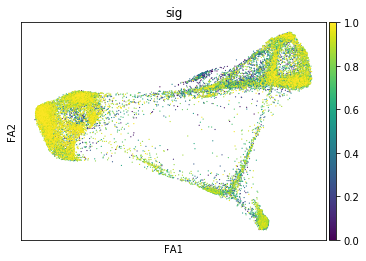

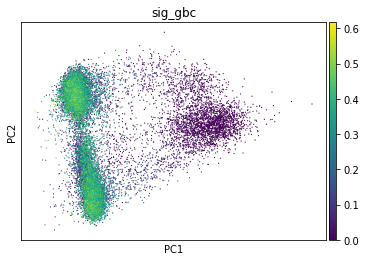

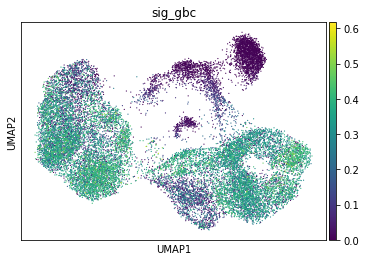

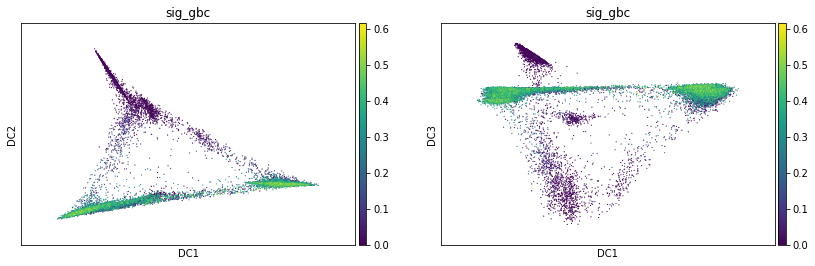

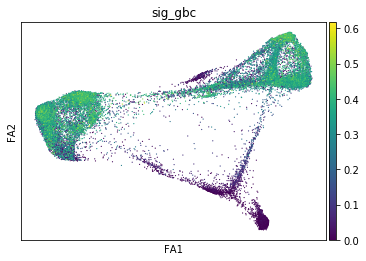

In [5]:
###readin
merged = qcs[0]
##visualize
res = 2.0
n_genes = 3000
sc.pp.highly_variable_genes(merged, flavor='cell_ranger', n_top_genes=n_genes)
merged = sceasy.visualize(merged,covariates=['n_counts','n_genes','mt_frac','phase','sample','leiden','dead','sig','sig_gbc'],res=res)

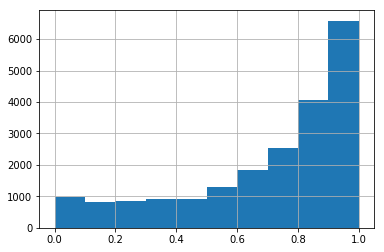

In [6]:
merged.obs.sig.hist()

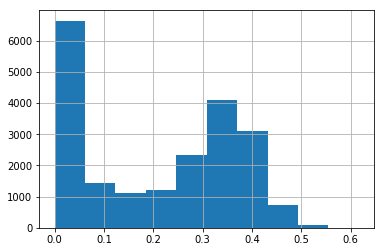

In [7]:
merged.obs.sig_gbc.hist()